<a href="https://colab.research.google.com/github/srilamaiti/ml_works/blob/main/comment_bertopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install -U sentence-transformers
!pip install bertopic==0.14.1
!pip install bertopic[flair]
!pip install bertopic[gensim]
!pip install bertopic[spacy]
!pip install bertopic[use]
!pip install emoji
!pip install advertools
!pip install hdbscan
#!pip uninstall umap
#!pip install umap-learn==0.5.3
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached protobuf-3.20.2-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.22.3
    Uninstalling protobuf-4.22.3:
      Successfully uninstalled protobuf-4.22.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensor

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer, TFBertModel

import sklearn as sk
import os
import nltk
from nltk.data import find

import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import advertools as adv
from nltk.corpus import stopwords
from wordcloud import WordCloud
#from umap import umap_ as UMAP
#import hdbscan # clustering



In [ ]:
df = pd.read_csv("comments.csv")
df

,Business Unit Name,EVP,Facility Type,District,Comment Language,Original Comment Text,English Comment,Compound Sentiment Score,Overall Sentiment,spl_char_chk,deEmojify_text,emoji_present_flag,all_punct_chk,english_comment_length
0,05R-Denver,"Griffith, Kelly",OF,60,en,I can step down and go back to being a pharmac...,I can step down and go back to being a pharmac...,-0.6908,Negative,False,I can step down and go back to being a pharmac...,False,False,277
1,05R-Denver,"Griffith, Kelly",OF,60,en,I have worked more hours than I would have lik...,I have worked more hours than I would have lik...,-0.4005,Negative,False,I have worked more hours than I would have lik...,False,False,278
2,05R-Denver,"Griffith, Kelly",OF,60,en,"Corporate SLT ""Thank You"" for implementing “Li...","Corporate SLT ""Thank You"" for implementing “Li...",-0.0258,Negative,False,"Corporate SLT ""Thank You"" for implementing “Li...",False,False,458
3,05R-Denver,"Griffith, Kelly",OF,60,en,We have made incredible strides in the Denver ...,We have made incredible strides in the Denver ...,0.0258,Positive,False,We have made incredible strides in the Denver ...,False,False,296
4,05R-Denver,"Griffith, Kelly",OF,60,en,"Work on benefits, seems poorer every year.","Work on benefits, seems poorer every year.",0.0258,Positive,False,"Work on benefits, seems poorer every year.",False,False,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58210,United,NaN,NaN,NaN,en,This is an amazing company to work with. In ou...,This is an amazing company to work with. In ou...,0.9947,Positive,False,This is an amazing company to work with. In ou...,False,False,1068
58211,United,NaN,NaN,NaN,en,"ever since I started working here, I have neve...","ever since I started working here, I have neve...",0.9949,Positive,False,"ever since I started working here, I have neve...",False,False,896
58212,United,NaN,NaN,NaN,en,Very good at working with request for days off...,Very good at working with request for days off...,0.9971,Positive,False,Very good at working with request for days off...,True,False,3213
58213,United,NaN,NaN,NaN,en,"I love working at my job it’s my happy place, ...","I love working at my job it’s my happy place, ...",0.9977,Positive,False,"I love working at my job it’s my happy place, ...",False,False,781


In [ ]:
def check(s):
    return all(i in string.punctuation for i in s)

def spl_char_chk(s):
    return s.lower() == s.upper()

def string_only_emoji_check(s):
    emoji_list = adv.extract_emoji(s)["emoji"]
    #print(emoji_list)
    merged_emoji_list = list(set(list(itertools.chain(*emoji_list))))
    #print(merged_emoji_list)
    if len(merged_emoji_list) == 0:
        return False
    else:
        return True

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def unify_whitespaces(text):
    cleaned_string = re.sub(' +', ' ', text )
    return cleaned_string

In [ ]:
df = df[~df["Overall Sentiment"].isna()]
df = df[~df["English Comment"].isna()]

df["English Comment"] = df["English Comment"].apply(lambda x : x.replace("\n","").replace("\t","").strip())
df["English Comment"] = df["English Comment"].apply(lambda x : unify_whitespaces(x))
df['English Comment'] = np.where(df['English Comment'] == "nan", "none", df['English Comment'] )
df['English Comment'] = np.where(df['English Comment'] == "", "none", df['English Comment'])
df['English Comment'] = np.where(df['English Comment'].str.lower == "none", "none", df['English Comment'])
df['English Comment'] = np.where(((df['English Comment'] == ".") | (df['English Comment'] == "..") | (df['English Comment'] == "...") | (df['English Comment'] == "....") | (df['English Comment'] == ".....") | (df['English Comment'] == "......") | (df['English Comment'] == ".......") | (df['English Comment'] == "........") | (df['English Comment'] == ".........") | (df['English Comment'] == "..........")), "none", df['English Comment'] )
df = df[df['English Comment'] != 'none']
df = df[df["English Comment"] != "!"]

df["spl_char_chk"] = df["English Comment"].apply(lambda x : check(x.strip()))
df["deEmojify_text"] = df["English Comment"].apply(lambda x : deEmojify(x.strip()))
df["emoji_present_flag"] = np.where(df["English Comment"] == df["deEmojify_text"], False, True)
df["all_punct_chk"] = df["English Comment"].apply(lambda x : spl_char_chk(x.strip()))

df = df[df["spl_char_chk"] == False]
df = df[df["all_punct_chk"] == False]

df = df[df["English Comment"].str.lower() != "None"]
df = df[df["English Comment"].str.lower() != "no"]
df = df[df["English Comment"].str.lower() != "na"]
df = df[df["English Comment"].str.lower() != "n/a"]
df = df[df["English Comment"].str.lower() != "none"]
df = df[df["English Comment"].str.lower() != "nothing"]
df = df[df["English Comment"].str.lower() != "not really"]
df = df[df["English Comment"].str.lower() != "love it"]
df = df[df["English Comment"].str.lower() != "love it!"]
df = df[df["English Comment"].str.lower() != "nothing!!"]
df = df[df["English Comment"].str.lower() != "nothing!"]
df = df[df["English Comment"].str.lower() != "i love it"]
df = df[df["English Comment"].str.lower() != "i love it!"]
df = df[df["English Comment"].str.lower() != "no comments"]
df = df[df["English Comment"].str.lower() != "no comments."]
df = df[df["English Comment"].str.lower() != "love my job"]
df = df[df["English Comment"] != "#NAME?"]
df = df[df["English Comment"] != "zero"]
df["english_comment_length"] = df["English Comment"].apply(lambda x : len(x))
sns.displot(df.english_comment_length, kde=False)
df = df[(df["english_comment_length"] > 25)]

len(df)

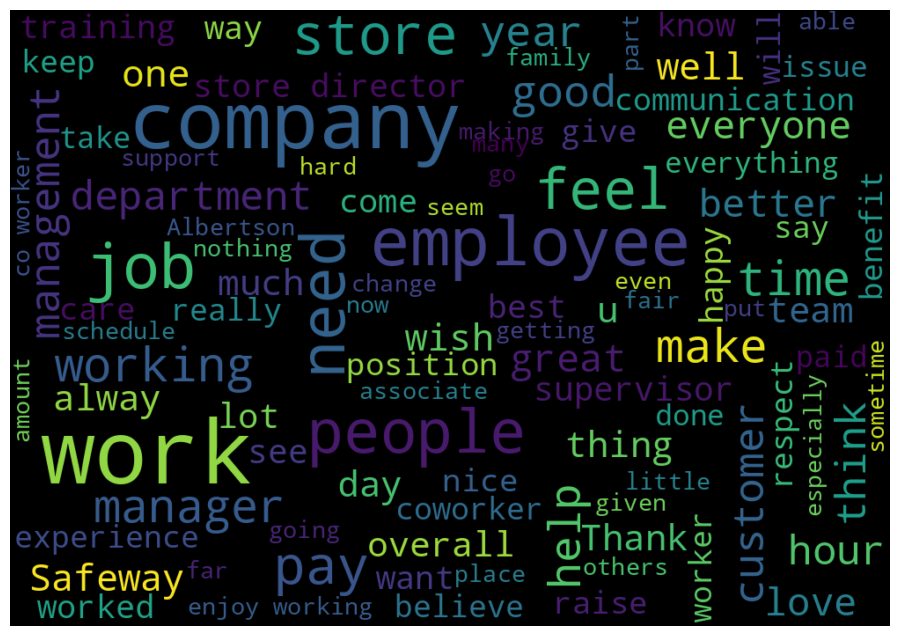

In [ ]:
txt = ' '.join(rev for rev in df["deEmojify_text"] )

plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100, 
    width=1000, 
    height=700
).generate(txt)

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.show()

In [ ]:
from bertopic import BERTopic
#from sklearn.feature_extraction.text import CountVectorizer
#topic_model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', vectorizer_model=None,min_topic_size= 15, nr_topics="auto", language = 'english',calculate_probabilities = True)
#topic_model=BERTopic()
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, nr_topics="auto")
comment_text = df['deEmojify_text'].values.tolist()
headline_topics, probs = topic_model.fit_transform(comment_text)

ImportError: ignored

In [ ]:
from bertopic import BERTopic
from umap.umap_ import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
topic_model = BERTopic(hdbscan_model=hdbscan_model,umap_model=umap_model, language="english", calculate_probabilities=True, verbose=True, nr_topics="auto")

comment_text = df['deEmojify_text'].values.tolist()
headline_topics, probs = topic_model.fit_transform(comment_text)

ImportError: ignored

In [ ]:
freq = topic_model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head()

In [ ]:
a_topic = freq.iloc[1]["Topic"] # Select the 1st topic
topic_model.get_topic(a_topic) # Show the words and their c-TF-IDF scores

In [ ]:
topic_model.visualize_barchart(top_n_topics=10)

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=10)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=10)

In [ ]:
similar_topics, similarity = topic_model.find_topics("pay", top_n = 5)
similar_topics 

In [ ]:
freq[freq["Topic"].isin(similar_topics)]

In [ ]:
# Get the clusterer model, the clusters' tree and the clusters (topics ids)
clusterer = topic_model.hdbscan_model
tree = clusterer.condensed_tree_
clusters = tree._select_clusters()

# Get the ids of the most relevant documents (exemplars) associated with the topic at index idx
c_exemplars = topic_model.get_most_relevant_documents(clusters[idx], tree)

In [ ]:
most_similar = similar_topics[0]
print("Most Similar Topic Info: \n{}".format(topic_model.get_topic(most_similar)))
print("Similarity Score: {}".format(similarity[0]))

In [ ]:
topic_model.find_topics("management")

In [ ]:
from bertopic import BERTopic
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
topic_model1 = BERTopic(hdbscan_model=hdbscan_model, language="english", calculate_probabilities=True, verbose=True, nr_topics="auto")
headline_topics1, probs1 = topic_model1.fit_transform(comment_text)

In [ ]:
topic_model1.visualize_barchart(top_n_topics=10)

In [ ]:
topic_model1.visualize_topics()

In [ ]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
topic_model2 = BERTopic(hdbscan_model=hdbscan_model, language="english", calculate_probabilities=True, verbose=True, nr_topics="auto", ctfidf_model=ctfidf_model)
headline_topics2, probs2 = topic_model2.fit_transform(comment_text)

In [ ]:
topic_model2.visualize_barchart(top_n_topics=10)

In [ ]:
topic_model2.visualize_topics()